#Importing the libraries

In [14]:
!pip install squarify

In [53]:
import numpy as np 
import pandas as pd 
import os
from statsmodels import api as sm
import pylab as py
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy.stats import kstest,norm
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics
from scipy.stats import chi2_contingency
import squarify

#For purpose of analysis let's take data from November 2019

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/2019-Nov.csv')

In [7]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:02 UTC,view,5802432,1487580009286598681,NaN,NaN,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
1,2019-11-01 00:00:09 UTC,cart,5844397,1487580006317032337,NaN,NaN,2.38,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
2,2019-11-01 00:00:10 UTC,view,5837166,1783999064103190764,NaN,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f
3,2019-11-01 00:00:11 UTC,cart,5876812,1487580010100293687,NaN,jessnail,3.16,564506666,186c1951-8052-4b37-adce-dd9644b1d5f7
4,2019-11-01 00:00:24 UTC,remove_from_cart,5826182,1487580007483048900,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635837 entries, 0 to 4635836
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 318.3+ MB


In [9]:
print("category_code ",df['category_code'].isnull().sum())
print("brand ",df['brand'].isnull().sum())
print("Both ",(df['category_code'].isnull() & df['brand'].isnull()).sum())

category_code  4560089
brand  1986029
Both  1966848


In [10]:
df.dropna()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
66,2019-11-01 00:04:33 UTC,purchase,5766980,1487580013053083824,stationery.cartrige,italwax,1.98,564451209,861ab2f1-b2e5-886f-a93b-5b067eff081f
67,2019-11-01 00:04:33 UTC,purchase,5767494,1487580013053083824,stationery.cartrige,italwax,2.14,564451209,861ab2f1-b2e5-886f-a93b-5b067eff081f
68,2019-11-01 00:04:33 UTC,purchase,5775813,1487580013053083824,stationery.cartrige,italwax,1.98,564451209,861ab2f1-b2e5-886f-a93b-5b067eff081f
69,2019-11-01 00:04:33 UTC,purchase,5775814,1487580013053083824,stationery.cartrige,italwax,1.98,564451209,861ab2f1-b2e5-886f-a93b-5b067eff081f
242,2019-11-01 00:16:56 UTC,view,5885596,1487580006350586771,appliances.environment.vacuum,polarus,102.38,202438687,8dc848f5-bac3-44d7-9414-75d4e599abaf
...,...,...,...,...,...,...,...,...,...
4634986,2019-11-30 23:28:47 UTC,view,5868559,1487580006350586771,appliances.environment.vacuum,max,95.08,579961417,4ee71910-3878-4a37-9ca7-3aa35e037d2f
4635434,2019-11-30 23:45:12 UTC,view,5856191,1487580006350586771,appliances.environment.vacuum,runail,24.44,526779351,0d56d4ab-0a70-4cd2-bb0c-e7e22ad53e20
4635442,2019-11-30 23:45:23 UTC,view,5395,1487580006350586771,appliances.environment.vacuum,runail,30.95,526779351,0d56d4ab-0a70-4cd2-bb0c-e7e22ad53e20
4635461,2019-11-30 23:45:46 UTC,view,5856191,1487580006350586771,appliances.environment.vacuum,runail,24.44,526779351,0d56d4ab-0a70-4cd2-bb0c-e7e22ad53e20


#Number of sellers by date

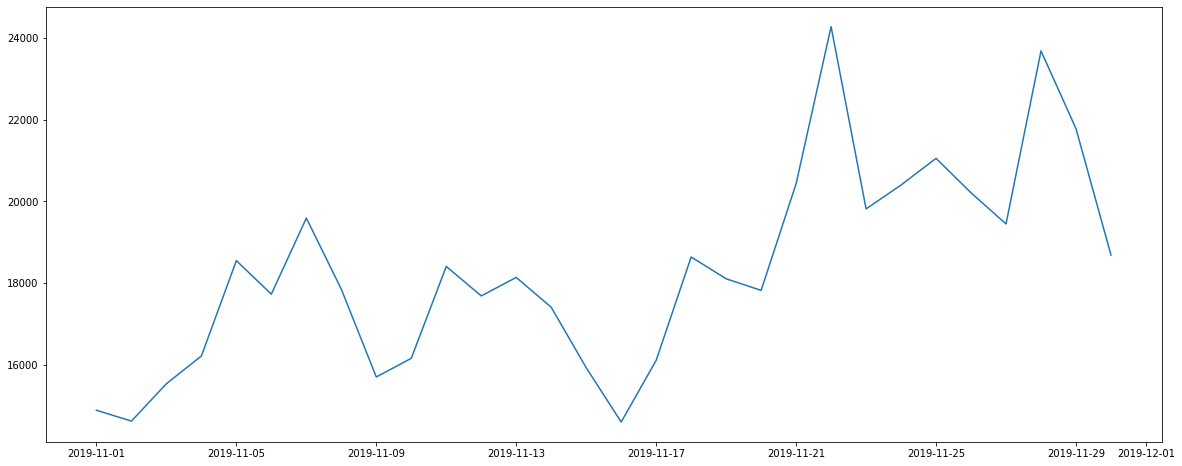

In [11]:
#No of visitors by date
data = df.loc[:,['event_time','user_id']]
#Extracting only dates
data['event_time'] = data['event_time'].apply(lambda s: str(s)[0:10])
visitor_by_date = data.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'], ascending=True)
x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(x,y)
plt.show()

#Most brought brands

In [12]:
df['brand'].value_counts()
df['event_type'].value_counts()

view                2076132
cart                1311807
remove_from_cart     925481
purchase             322417
Name: event_type, dtype: int64

            event_time  event_type  product_id  category_id  category_code  \
brand                                                                        
airnails         19979       19979       19979        19979              0   
almea             1094        1094        1094         1094              0   
andrea             101         101         101          101              0   
ardell            4416        4416        4416         4416              0   
art-visage       15206       15206       15206        15206              0   
...                ...         ...         ...          ...            ...   
ypsed              542         542         542          542              2   
yu-r               586         586         586          586              0   
zab                 19          19          19           19              0   
zeitun            3480        3480        3480         3480              0   
zinger           22287       22287       22287        22287     

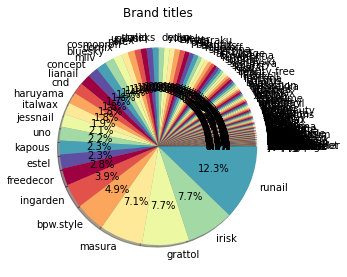

In [13]:
title_type = df.groupby('brand').agg('count')
print(title_type)
type_labels = title_type.user_id.sort_values().index
type_counts = title_type.user_id.sort_values()
plt.figure(1,figsize =(20,10))
the_grid = GridSpec(2,2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0,1,8)]
plt.subplot(the_grid[0,1],aspect=1,title = 'Brand titles')
type_show_ids = plt.pie(type_counts,labels = type_labels,autopct = '%1.1f%%',shadow = True,colors = colors)
plt.show()

#Popular product categories

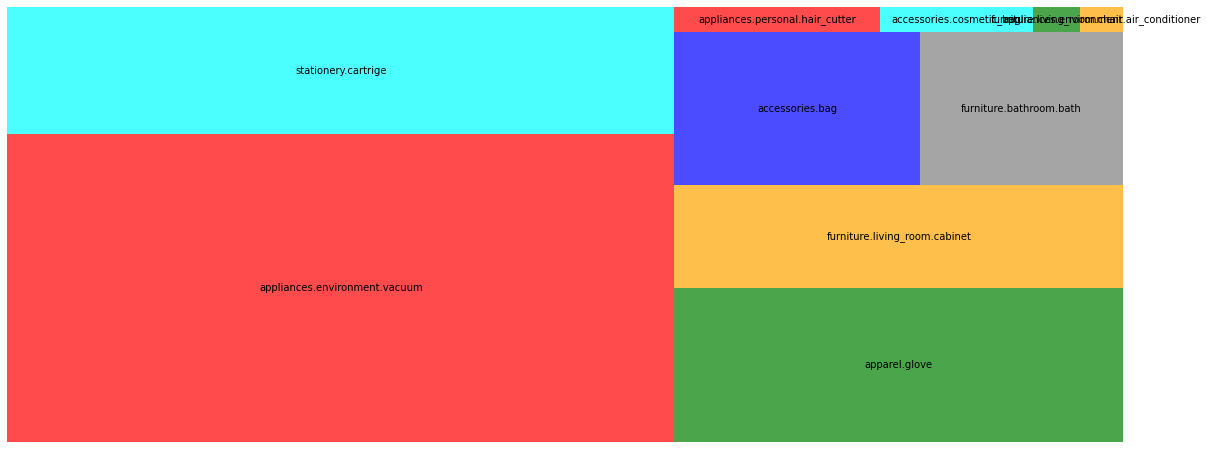

In [16]:
top_category_n = 30
top_category = df.loc[:,'category_code'].value_counts()[:top_category_n].sort_values(ascending=False)
squarify.plot(sizes=top_category, label=top_category.index.array, color=["red","cyan","green","orange","blue","grey"], alpha=.7  )
plt.axis('off')
plt.show()

ValueError: ignored

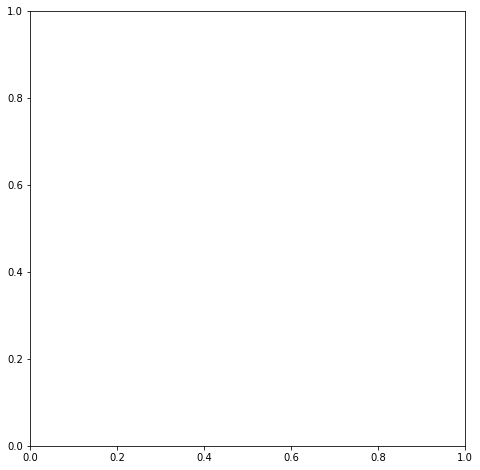

In [18]:
labels = ['view', 'cart','purchase', 'remove_from_cart']
size = df['event_type'].value_counts()
colors = ['yellowgreen', 'lightskyblue','lightcoral']
explode = [0, 0.1,0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event_Type', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

#Conversion rates

1.Count of people who viewed the item.

2.Count of people who added the item to cart.

3.Count of people who bought the item.

In [20]:
view_count = df['event_type'].value_counts()[0]
cart_count = df['event_type'].value_counts()[1]
purchase_count = df['event_type'].value_counts()[2]
print("Rate of conversion between view and purchase events" + ' '+str((purchase_count/view_count)*100) +'%')
print("Rate of conversion between view and add to cart events" + ' '+str((cart_count/view_count)*100) +'%')
print("Rate of conversion between add to cart and purchase events" + ' '+str((purchase_count/cart_count)*100) +'%')

Rate of conversion between view and purchase events 44.57717524704595%
Rate of conversion between view and add to cart events 63.18514429718341%
Rate of conversion between add to cart and purchase events 70.55008854198826%


#Brands

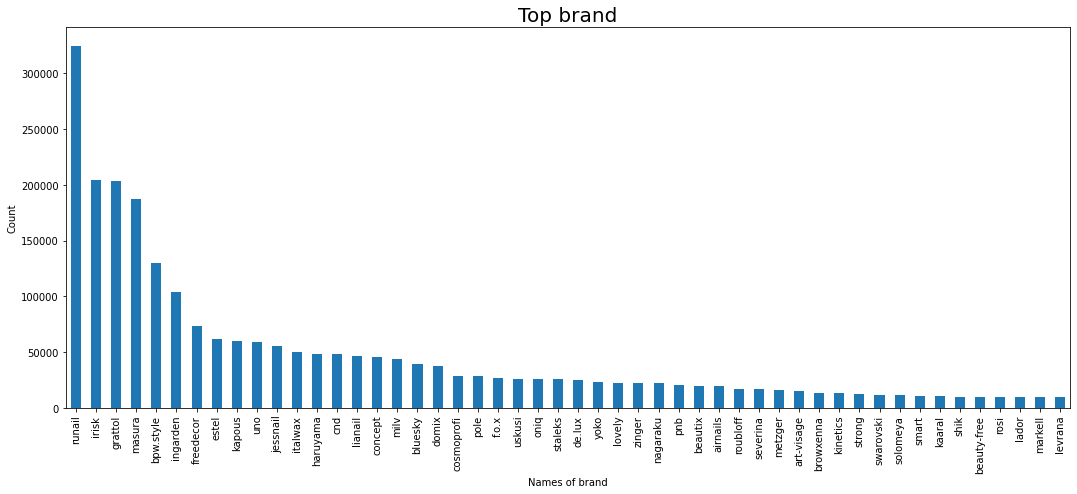

In [21]:
df['brand'].value_counts().head(50).plot.bar(figsize = (18,7))
plt.title('Top brand',fontsize = 20)
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show()

runail        25997
irisk         16364
grattol       13613
bpw.style     12985
masura        11435
              ...  
sun               1
helloganic        1
ovale             1
neoleor           1
skipofit          1
Name: brand, Length: 213, dtype: int64


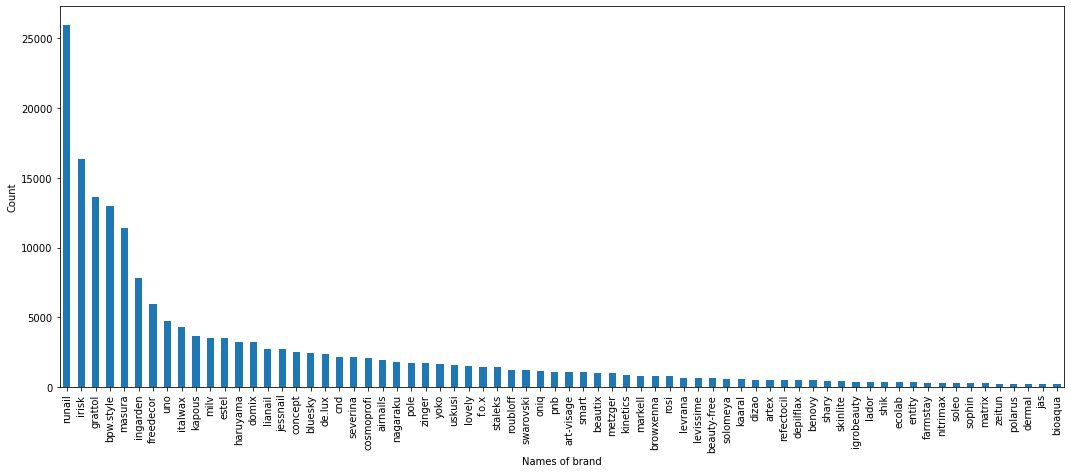

In [22]:
d = df.loc[df['event_type'].isin(['purchase'])].drop_duplicates()
print(d['brand'].value_counts())
d['brand'].value_counts().head(70).plot.bar(figsize =(18,7))
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show()

In [24]:
top_player = df['brand'].value_counts()[0]
second_player = df['brand'].value_counts()[1]
last_player = df['brand'].value_counts()[-1]
print("Top brand saw " + ''+str((top_player/second_player)*100)+' '+"%more sales than second_player in the market")
print("Top brand saw " +''+str((top_player/last_player)*100)+' '+"%more sales than bottom player in the market")

Top brand saw 159.11695843415396 %more sales than second_player in the market
Top brand saw 32485000.0 %more sales than bottom player in the market


#List of people who has bought or added products to the cart

In [26]:
cart_purchase_users = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
print(cart_purchase_users)

                      event_time event_type  product_id          category_id  \
376      2019-11-01 00:29:32 UTC       cart     5749199  1487580013053083824   
446      2019-11-01 00:34:01 UTC       cart     5885590  1487580006350586771   
980      2019-11-01 01:08:03 UTC       cart     5749199  1487580013053083824   
2515     2019-11-01 02:37:04 UTC       cart     5823936  1487580006350586771   
5936     2019-11-01 04:39:47 UTC       cart     5767493  1487580013053083824   
...                          ...        ...         ...                  ...   
4602929  2019-11-30 19:12:05 UTC       cart     5810084  1487580006350586771   
4608048  2019-11-30 19:35:16 UTC       cart     5856191  1487580006350586771   
4613282  2019-11-30 20:00:16 UTC       cart     5749198  1487580013053083824   
4616301  2019-11-30 20:13:25 UTC       cart     5810082  1487580006350586771   
4633927  2019-11-30 22:59:09 UTC       cart     5856193  2193074740619379535   

                         category_code 

#All activities of above users including view event

In [27]:
cart_purchase_users_all_activity = df.loc[df['user_id'].isin(cart_purchase_users['user_id'])]
print(cart_purchase_users_all_activity)

                      event_time event_type  product_id          category_id  \
252      2019-11-01 00:18:27 UTC       view     5743974  1487580013053083824   
365      2019-11-01 00:28:53 UTC       view     5657900  1487580013053083824   
376      2019-11-01 00:29:32 UTC       cart     5749199  1487580013053083824   
382      2019-11-01 00:29:59 UTC       cart     5775814  1487580013053083824   
387      2019-11-01 00:30:07 UTC       view     5885590  1487580006350586771   
...                          ...        ...         ...                  ...   
4633396  2019-11-30 22:45:46 UTC       view     5560758  1487580006300255120   
4633469  2019-11-30 22:47:52 UTC       view     5854573  1487580006350586771   
4633927  2019-11-30 22:59:09 UTC       cart     5856193  2193074740619379535   
4633936  2019-11-30 22:59:26 UTC       view     5856193  2193074740619379535   
4634032  2019-11-30 23:02:00 UTC       view     5774248  2193074740619379535   

                         category_code 

##Counting no of activities in one session

In [28]:
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type":"activity_count"})
print(activity_in_session)

                              user_session  activity_count
0     0014f534-f34d-47b9-9720-363d184b21b9               1
1     0036d3ff-652f-4cc7-b1f0-b7d23ecfc092               4
2     003c1d09-749a-44b2-b0af-9c82c9a11182              70
3     0043a9c0-6a69-4a8e-bad0-e065c2797118               1
4     0048da97-22ea-4d7b-a2c2-4a376f754a51               1
...                                    ...             ...
6861  ffe1f40e-242a-4a39-926b-e5df4321bf61               1
6862  ffe2ee5c-2b63-46f8-b7bd-090e9f0b4966               3
6863  ffe84b00-701e-4501-8e07-f7e41c44600c              11
6864  fff32e24-e6c9-4aca-a600-ba16c33c5c45              18
6865  fff6d5a8-c813-48d2-a9e2-49db9d500bfa               1

[6866 rows x 2 columns]


In [29]:
def convert_time_to_date(utc_timestamp):
  utc_date = datetime.strptime(utc_timestamp[0:10],'%Y-%m-%d').date()
  return utc_date

##Extract event date from event_time column and find on which date the activity occurs

In [30]:
df['event_date'] = df['event_time'].apply(lambda s:convert_time_to_date(s))

Splitting of category and sub category is done by string handling

In [32]:
df_targets = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset = ['event_type','product_id','price','user_id','user_session'])
df_targets["is_purchased"] = np.where(df_targets["event_type"]=="purchase",1,0)
df_targets["is_purchased"] = df_targets.groupby(["user_session","product_id"])["is_purchased"].transform("max")
df_targets = df_targets.loc[df_targets["event_type"]=='cart'].drop_duplicates(["user_session","product_id","is_purchased"])
df_targets['event_weekday'] = df_targets['event_date'].apply(lambda s:s.weekday())
df_targets.dropna(how = 'any',inplace = True)
df_targets["category_code_level1"] = df_targets["category_code"].str.split(",",expand = True)[0].astype('category')

In [33]:
df_targets = df_targets.merge(activity_in_session, on = 'user_session',how ='left')
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,is_purchased,event_weekday,category_code_level1,activity_count
0,2019-11-01 00:29:32 UTC,cart,5749199,1487580013053083824,stationery.cartrige,italwax,1.98,457604149,34adbc64-eebc-4d45-8542-547b9c20f6c1,2019-11-01,1.0,4,stationery.cartrige,17.0
1,2019-11-01 00:29:59 UTC,cart,5775814,1487580013053083824,stationery.cartrige,italwax,1.98,457604149,34adbc64-eebc-4d45-8542-547b9c20f6c1,2019-11-01,1.0,4,stationery.cartrige,17.0
2,2019-11-01 00:30:24 UTC,cart,5788783,1487580013053083824,stationery.cartrige,italwax,1.98,457604149,34adbc64-eebc-4d45-8542-547b9c20f6c1,2019-11-01,1.0,4,stationery.cartrige,17.0
3,2019-11-01 00:30:49 UTC,cart,5855510,1487580006350586771,appliances.environment.vacuum,max,95.08,513114494,4d9cd992-d34d-4dc4-abe8-0f941ae1fa97,2019-11-01,0.0,4,appliances.environment.vacuum,0.0
4,2019-11-01 00:34:01 UTC,cart,5885590,1487580006350586771,appliances.environment.vacuum,polarus,78.57,566283723,b023f80f-362b-43fe-a3b0-d32279f42a82,2019-11-01,0.0,4,appliances.environment.vacuum,5.0


In [34]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8763 entries, 0 to 8762
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   event_time            8763 non-null   object  
 1   event_type            8763 non-null   object  
 2   product_id            8763 non-null   int64   
 3   category_id           8763 non-null   int64   
 4   category_code         8763 non-null   object  
 5   brand                 8763 non-null   object  
 6   price                 8763 non-null   float64 
 7   user_id               8763 non-null   int64   
 8   user_session          8763 non-null   object  
 9   event_date            8763 non-null   object  
 10  is_purchased          8763 non-null   float64 
 11  event_weekday         8763 non-null   int64   
 12  category_code_level1  8763 non-null   category
 13  activity_count        8763 non-null   float64 
dtypes: category(1), float64(3), int64(4), object(6)
memory u

In [35]:
df_targets.to_csv('training_data.csv')

In [36]:
df_targets = pd.read_csv('training_data.csv')

In [37]:
df_targets.head()

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,is_purchased,event_weekday,category_code_level1,activity_count
0,0,2019-11-01 00:29:32 UTC,cart,5749199,1487580013053083824,stationery.cartrige,italwax,1.98,457604149,34adbc64-eebc-4d45-8542-547b9c20f6c1,2019-11-01,1.0,4,stationery.cartrige,17.0
1,1,2019-11-01 00:29:59 UTC,cart,5775814,1487580013053083824,stationery.cartrige,italwax,1.98,457604149,34adbc64-eebc-4d45-8542-547b9c20f6c1,2019-11-01,1.0,4,stationery.cartrige,17.0
2,2,2019-11-01 00:30:24 UTC,cart,5788783,1487580013053083824,stationery.cartrige,italwax,1.98,457604149,34adbc64-eebc-4d45-8542-547b9c20f6c1,2019-11-01,1.0,4,stationery.cartrige,17.0
3,3,2019-11-01 00:30:49 UTC,cart,5855510,1487580006350586771,appliances.environment.vacuum,max,95.08,513114494,4d9cd992-d34d-4dc4-abe8-0f941ae1fa97,2019-11-01,0.0,4,appliances.environment.vacuum,0.0
4,4,2019-11-01 00:34:01 UTC,cart,5885590,1487580006350586771,appliances.environment.vacuum,polarus,78.57,566283723,b023f80f-362b-43fe-a3b0-d32279f42a82,2019-11-01,0.0,4,appliances.environment.vacuum,5.0


#Resampling data to have equal no of purchased and not purchased items

In [38]:
is_purchase_set = df_targets[df_targets['is_purchased'] == 1]
is_purchase_set.shape[0]
not_purchase_set = df_targets[df_targets['is_purchased'] == 0]
not_purchase_set.shape[0]

7141

In [40]:
n_samples = 500000
is_purchase_downsampled = resample(is_purchase_set,replace = True,n_samples = n_samples,random_state = 27)
not_purchase_set_downsampled = resample(not_purchase_set,replace = True,n_samples = n_samples,random_state = 27)

In [41]:
downsampled = pd.concat([is_purchase_downsampled,not_purchase_set_downsampled])
downsampled['is_purchased'].value_counts()

1.0    500000
0.0    500000
Name: is_purchased, dtype: int64

In [43]:
features = downsampled[['brand','price','event_weekday','category_code_level1','activity_count']]

#Encoding categorical attributes

In [50]:
features.loc[:,'brand'] = LabelEncoder().fit_transform(downsampled.loc[:,'brand'].copy())
features.loc[:,'event_weekday'] = LabelEncoder().fit_transform(downsampled.loc[:,'event_weekday'].copy())
features.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level1'].copy())
is_purchased = LabelEncoder().fit_transform(downsampled['is_purchased'])
features.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,brand,price,event_weekday,category_code_level1,activity_count
5684,9,1.78,4,8,43.0
2833,0,5.57,1,2,0.0
4017,7,16.67,5,6,0.0
7019,9,1.98,0,8,0.0
5704,0,5.22,4,2,0.0


In [51]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 5684 to 5371
Data columns (total 5 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   brand                 1000000 non-null  int64  
 1   price                 1000000 non-null  float64
 2   event_weekday         1000000 non-null  int64  
 3   category_code_level1  1000000 non-null  int64  
 4   activity_count        1000000 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 45.8 MB


#Chi square test - association between two attributes

Weekday vs price

In [54]:
print()
print("Chi square test")
#Event weekday and price
table = pd.crosstab(features['event_weekday'],features['price'],margins = False)
stat,p,dof,expected = chi2_contingency(table)
alpha = 0.05
print("For weekday of the event and price")
print("p value is " +str(p))
if p >= alpha:
  print("No significant association between these attributes -H0 holds true")
else:
  print("significant association between these attributes -H0 is rejected")


Chi square test
For weekday of the event and price
p value is 0.0
significant association between these attributes -H0 is rejected


user_id vs category_id

In [56]:
d1 = df[:100000]
table1 = pd.crosstab(d1['category_id'],d1['user_id'],margins = False)
stat,p,dof,expected = chi2_contingency(table1)
alpha = 0.05
print("For category code and user")
print("p value is " +str(p))
if p >= alpha:
  print("No significant association between these attributes -H0 holds true")
else:
  print("significant association between these attributes -H0 is rejected")

For category code and user
p value is 0.0
significant association between these attributes -H0 is rejected


#Covariance matrix

In [61]:
matrix = downsampled[['brand','price','event_weekday','category_code_level1','activity_count','is_purchased']]
matrix.loc[:,'brand'] = LabelEncoder().fit_transform(downsampled.loc[:,'brand'].copy())
matrix.loc[:,'event_weekday'] = LabelEncoder().fit_transform(downsampled.loc[:,'event_weekday'].copy())
matrix.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level1'].copy())
matrix.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,brand,price,event_weekday,category_code_level1,activity_count,is_purchased
5684,9,1.78,4,8,43.0,1.0
2833,0,5.57,1,2,0.0,1.0
4017,7,16.67,5,6,0.0,1.0
7019,9,1.98,0,8,0.0,1.0
5704,0,5.22,4,2,0.0,1.0


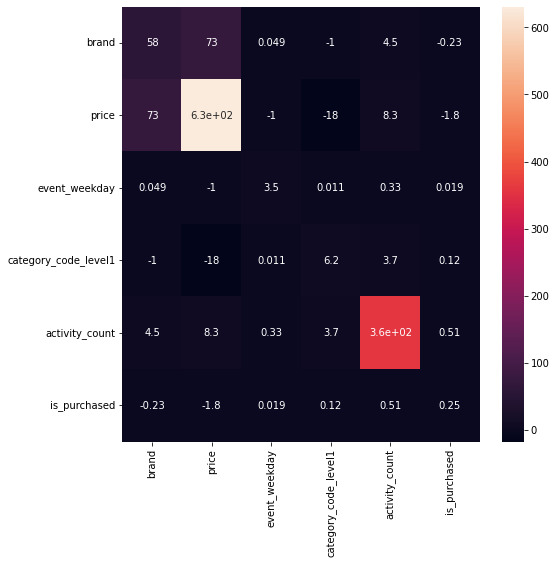

In [62]:
cov_matrix = matrix.cov()
sns.heatmap(cov_matrix,annot = True)
plt.show()

#Correlation matrix

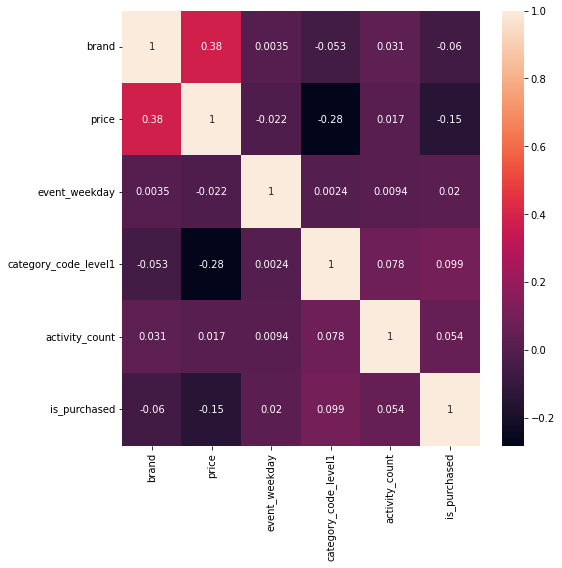

In [63]:
corr_matrix = matrix.corr()
sns.heatmap(corr_matrix,annot = True)
plt.show()

#ML models

In [64]:
X_train ,X_test , y_train, y_test = train_test_split(features,is_purchased,test_size = 0.25,random_state =0)

In [67]:
y_train

array([0, 1, 0, ..., 1, 1, 0])

#Decision tree classification

In [69]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

In [70]:
print("Accuracy",metrics.accuracy_score(y_test,y_pred))
print("Precision",metrics.precision_score(y_test,y_pred))
print("Recall",metrics.recall_score(y_test,y_pred))
print("fbeta",metrics.fbeta_score(y_test,y_pred,average = 'weighted',beta=0.5))

Accuracy 0.771504
Precision 0.7327991651046709
Recall 0.8542705523583887
fbeta 0.7741389729993505


#XGBoost classification

In [72]:
from xgboost import XGBClassifier
xg_model = XGBClassifier(learning_rate = 0.1)
xg_model.fit(X_train,y_train)
y_pred = xg_model.predict(X_test)

In [73]:
print("Accuracy",metrics.accuracy_score(y_test,y_pred))
print("Precision",metrics.precision_score(y_test,y_pred))
print("Recall",metrics.recall_score(y_test,y_pred))
print("fbeta",metrics.fbeta_score(y_test,y_pred,average = 'weighted', beta=0.5))

Accuracy 0.637708
Precision 0.6191919752486924
Recall 0.7144320737651777
fbeta 0.6379259513012243


#Logistic regression

In [74]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model = log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

In [76]:
print("Accuracy",metrics.accuracy_score(y_test,y_pred))
print("Precision",metrics.precision_score(y_test,y_pred))
print("Recall",metrics.recall_score(y_test,y_pred))
print("fbeta",metrics.fbeta_score(y_test,y_pred,average = 'weighted',beta=0.5))

Accuracy 0.574664
Precision 0.5702652273431185
Recall 0.604224529162698
fbeta 0.5745598502660856
